In [4]:
! pip install numpy pandas matplotlib seaborn scikit-learn -q

# Задание 3. LogReg.

*Логистическая регрессия* — модель для бинарной классификации, оценивает вероятность P(Y=1|X) через логит-функцию:
\( P(Y=1|X)=\sigma(w^T X + b) = 1/(1+e^{-(w^T X + b)}) \).
Параметры находятся максимизацией лог-правдоподобия (в sklearn — оптимизатор). ROC-кривая показывает компромисс
между чувствительностью (TPR) и 1-специфичностью (FPR) при разных порогах. Бутстрэп используется для оценки
неопределенности (CI) интересующих метрик.

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.utils import resample
from itertools import product, combinations
import warnings
warnings.filterwarnings('ignore')
from typing import Dict, Tuple

In [58]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
rng = np.random.RandomState(RANDOM_STATE)

sns.set(style="whitegrid")

## [1] Используя функцию make_blobs с любым random_state, сгенерировать датасет df, в котором есть три класса с размером каждого класса 100 объектов и восемь количественных (недискретных) признаков, при этом центры классов зафиксированы в следующих точках: 
- Класс 0 – (+1,+1,+1,+1,+1,+1,+1,+1), 
- Класс 1 – (-1,-1,-1,-1,-1,-1,-1,-1),
- Класс 2 – (+1,-1,+1,-1,+1,-1,+1,-1).
# Не забываем повторять шаги задания 1:
- ключевые характеристики датасета - корреляции
- визуализация на всех парах переменных

In [28]:
n_classes = 3
n_samples_per_class = 100
n_features = 8

centers = np.array([
    [ 1,  1,  1,  1,  1,  1,  1,  1],   
    [-1, -1, -1, -1, -1, -1, -1, -1],   
    [ 1, -1,  1, -1,  1, -1,  1, -1],   
])

X, y = make_blobs(
    n_samples=n_samples_per_class * n_classes,
    centers=centers,
    cluster_std=0.7,
    random_state=42
)

feature_names = [f"X{i+1}" for i in range(n_features)]

df = pd.DataFrame(X, columns=feature_names)
df["target"] = y
df["target_name"] = df["target"].map({
    0: "class_0",
    1: "class_1",
    2: "class_2"
})

df.head()


X1        X2        X3        X4        X5        X6        X7  \
0  0.170801 -0.706687 -1.493508 -1.039038 -0.609171 -0.946796 -0.622871   
1 -1.014957 -1.523048 -2.696968 -0.381168 -0.484209 -1.196929 -0.953106   
2  1.117923 -0.077682  0.295420 -0.202085  1.921981 -1.082648 -0.485298   
3  0.299768 -1.474421  1.359735 -0.874293  1.245441 -0.657569  1.444305   
4  1.817447  1.178095  1.236322  0.711686  0.658676  0.697209  1.276116   

         X8  target target_name  
0 -1.644472       1     class_1  
1 -0.638843       1     class_1  
2 -1.425475       2     class_2  
3 -0.223210       2     class_2  
4  0.705311       0     class_0

In [29]:
def dataset_overview_local(df_local: pd.DataFrame) -> None:
    print(f"Размер датасета: {df_local.shape}")
    print(f"Количество признаков: {len(feature_columns)}")
    print(f"Количество классов: {df_local['target'].nunique()}")
    print("Количество объектов по классам:")
    print(df_local['target_name'].value_counts())
    percent_missing = (df_local.isnull().sum() / len(df_local) * 100).round(2)
    print("Процент пропусков по признакам:")
    print(percent_missing)
    display(df_local.describe())

print('Dataset overview')
dataset_overview_local(df)

Dataset overview
Размер датасета: (300, 10)
Количество признаков: 8
Количество классов: 3
Количество объектов по классам:
target_name
class_1    100
class_2    100
class_0    100
Name: count, dtype: int64
Процент пропусков по признакам:
X1             0.0
X2             0.0
X3             0.0
X4             0.0
X5             0.0
X6             0.0
X7             0.0
X8             0.0
target         0.0
target_name    0.0
dtype: float64


X1          X2          X3          X4          X5          X6  \
count  300.000000  300.000000  300.000000  300.000000  300.000000  300.000000   
mean     0.327862   -0.230944    0.340226   -0.276528    0.348640   -0.333880   
std      1.118462    1.174921    1.179790    1.173779    1.070882    1.104796   
min     -2.749584   -2.696716   -2.787745   -3.058272   -2.395615   -3.027379   
25%     -0.539063   -1.134586   -0.641403   -1.184682   -0.491737   -1.166444   
50%      0.589398   -0.404119    0.541902   -0.506438    0.517359   -0.541645   
75%      1.179867    0.708590    1.307868    0.598480    1.141057    0.531332   
max      2.688831    3.696912    2.792059    2.904118    2.620261    2.533319   

               X7          X8      target  
count  300.000000  300.000000  300.000000  
mean     0.345834   -0.344716    1.000000  
std      1.123707    1.179139    0.817861  
min     -2.285344   -3.044945    0.000000  
25%     -0.593728   -1.243052    0.000000  
50%      0.515476   -0.593451    1.000000  
75%      1.190411    0.572330    2.000000  
max      3.155217    2.589485    2.000000

Pairplot по всем признакам


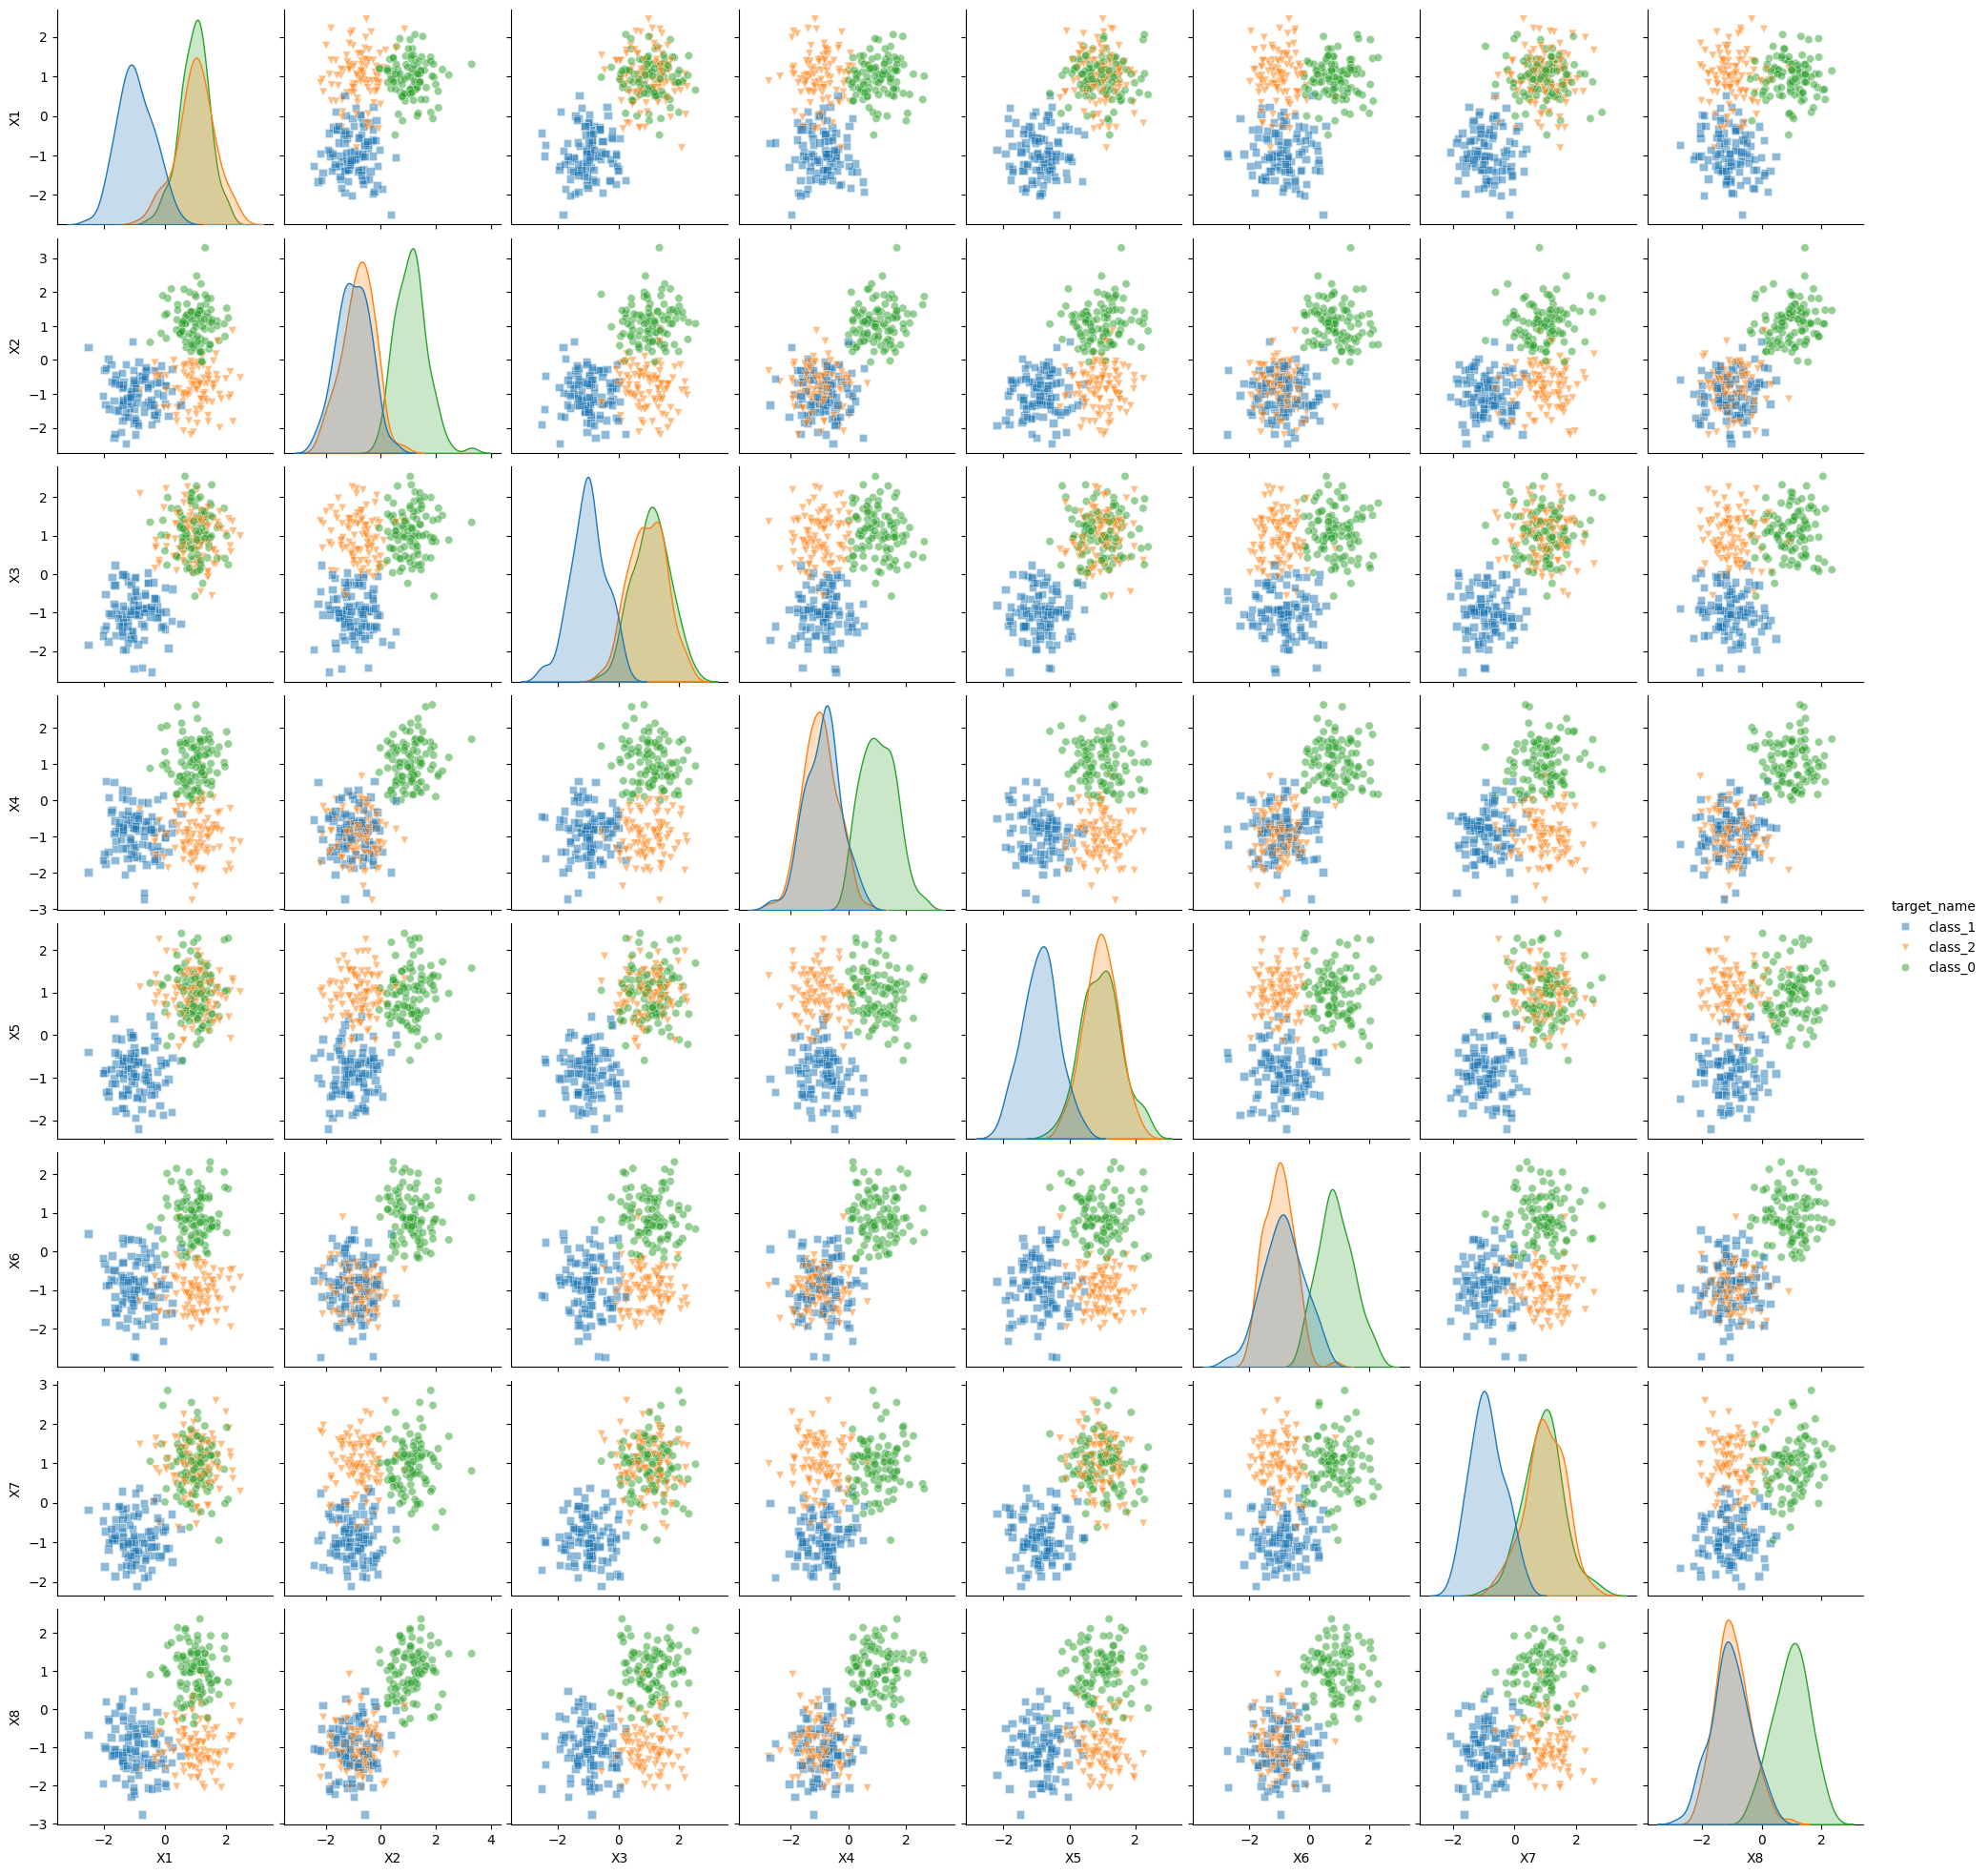

In [17]:
print('Pairplot по всем признакам')
sns.pairplot(df[feature_columns + ['target_name']], hue='target_name', markers=['s','v','o'], plot_kws={'alpha':0.5})
plt.show()

Correlation matrices (Pearson/Spearman)


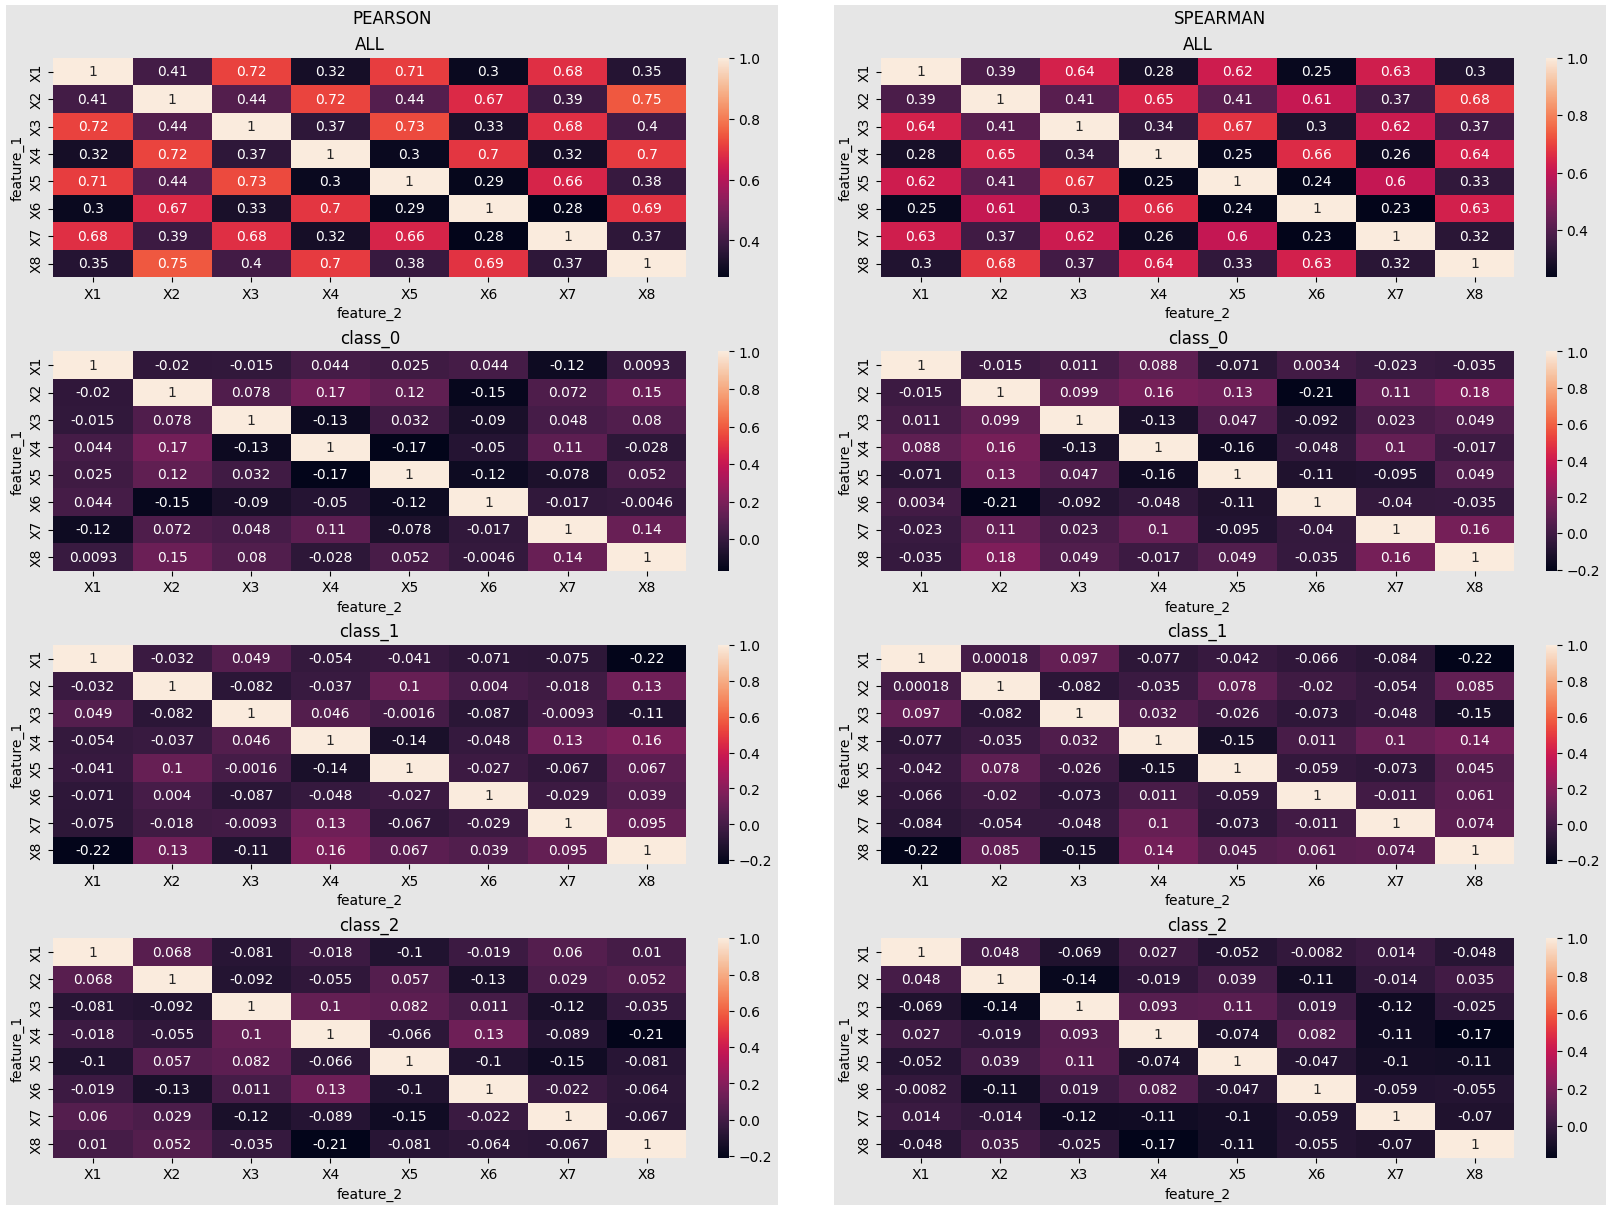

In [23]:
from scipy import stats as _stats

def compute_corr_pair_local(x: pd.Series, y: pd.Series, method: str) -> Tuple[float, float]:
    corr_func = _stats.pearsonr if method == "pearson" else _stats.spearmanr
    corr, p_val = corr_func(x, y)
    return corr, p_val

def compute_corr_df_local(df_local: pd.DataFrame, method: str) -> pd.DataFrame:
    rows = [
        {"feature_1": f1, "feature_2": f2, "corr": corr, "p_value": p_val}
        for f1 in df_local.columns
        for f2 in df_local.columns
        for corr, p_val in [compute_corr_pair_local(df_local[f1], df_local[f2], method)]
    ]
    return pd.DataFrame(rows)

def corr_matrix_from_df_local(corr_df: pd.DataFrame) -> pd.DataFrame:
    pivot = corr_df.pivot(index='feature_1', columns='feature_2', values='corr')
    return pivot.astype(float)

def draw_corr_matrices_local(all_objects: pd.DataFrame, objects_by_class_local: Dict[str, pd.DataFrame], class_names_local: list) -> plt.Figure:
    fig = plt.figure(layout="constrained", figsize=(16, 12))
    subfigs = fig.subfigures(1, 2, wspace=0.07)

    for i, method in enumerate(["pearson", "spearman"]):
        axs = subfigs[i].subplots(1 + len(class_names_local), 1)
        subfigs[i].suptitle(method.upper())
        subfigs[i].set_facecolor("0.9")

        # Корреляции по всем объектам
        corr_df = compute_corr_df_local(all_objects, method)
        sns.heatmap(corr_matrix_from_df_local(corr_df), annot=True, ax=axs[0])
        axs[0].set_title("ALL")
        # print(f"{method.upper()} correlations - all objects")
        # display(corr_df)

        # Корреляции по классам
        for j, cls in enumerate(class_names_local):
            corr_df_cls = compute_corr_df_local(objects_by_class_local[cls], method)
            sns.heatmap(corr_matrix_from_df_local(corr_df_cls), annot=True, ax=axs[j + 1])
            axs[j + 1].set_title(cls)
            # print(f"{method.upper()} correlations - {cls}")
            # display(corr_df_cls)

    return fig

print('Correlation matrices (Pearson/Spearman)')
all_objects_local = df[feature_columns]
corr_matrices_fig = draw_corr_matrices_local(all_objects_local, objects_by_class, class_names)
plt.show()


## [2] На основе созданного в пункте [1] датасета df сгенерировать отдельные дополнительные датасеты (df_A_B), в которых к классу 0 добавлено A одинаковых точек с координатами (-B,+B,-B,+B,-B,+B,-B,+B), где A = 1, 10, 100 и B = 1, 10, 100, при этом количество объектов в остальных классах неизменно

In [30]:
A_values = [1, 10, 100]
B_values = [1, 10, 100]

duplicate_point_template = lambda B: np.array(
    [-B, +B, -B, +B, -B, +B, -B, +B]
)

In [31]:
def generate_df_A_B(df_base, A, B, feature_names):
    dup_point = duplicate_point_template(B)

    dup_df = pd.DataFrame(
        np.tile(dup_point, (A, 1)),
        columns=feature_names
    )
    dup_df["target"] = 0
    dup_df["target_name"] = "class_0"

    df_A_B = pd.concat([df_base, dup_df], ignore_index=True)
    return df_A_B


In [32]:
df_variants = {}
df_variants["df"] = df  # исходный датасет тоже включаем

for A in A_values:
    for B in B_values:
        key = f"df_A{A}_B{B}"
        df_variants[key] = generate_df_A_B(
            df_base=df,
            A=A,
            B=B,
            feature_names=feature_names
        )

In [34]:
def generate_df_A_B(df_base, A, B, feature_names):
    dup_point = duplicate_point_template(B)

    dup_df = pd.DataFrame(
        np.tile(dup_point, (A, 1)),
        columns=feature_names
    )
    dup_df["target"] = 0
    dup_df["target_name"] = "class_0"

    df_A_B = pd.concat([df_base, dup_df], ignore_index=True)
    return df_A_B

In [35]:
df_variants = {}
df_variants["df"] = df 

for A in A_values:
    for B in B_values:
        key = f"df_A{A}_B{B}"
        df_variants[key] = generate_df_A_B(
            df_base=df,
            A=A,
            B=B,
            feature_names=feature_names
        )

In [36]:
summary = []

for name, dfi in df_variants.items():
    counts = dfi["target_name"].value_counts().to_dict()
    summary.append({
        "dataset": name,
        "class_0": counts.get("class_0", 0),
        "class_1": counts.get("class_1", 0),
        "class_2": counts.get("class_2", 0),
        "total": len(dfi)
    })

pd.DataFrame(summary).sort_values("dataset")


dataset  class_0  class_1  class_2  total
0            df      100      100      100    300
7    df_A100_B1      200      100      100    400
8   df_A100_B10      200      100      100    400
9  df_A100_B100      200      100      100    400
4     df_A10_B1      110      100      100    310
5    df_A10_B10      110      100      100    310
6   df_A10_B100      110      100      100    310
1      df_A1_B1      101      100      100    301
2     df_A1_B10      101      100      100    301
3    df_A1_B100      101      100      100    301

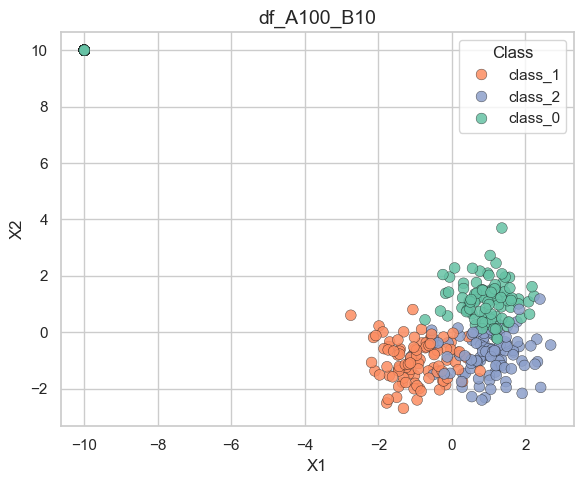

In [60]:
PALETTE = sns.color_palette("Set2", 8)
CLASS_COLORS = {"class_0": PALETTE[0], "class_1": PALETTE[1], "class_2": PALETTE[2]}

example_key = "df_A100_B10"
example_df = df_variants[example_key]

plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=example_df,
    x="X1",
    y="X2",
    hue="target_name",
    palette=CLASS_COLORS,
    s=60,
    edgecolor="k",
    linewidth=0.3,
    alpha=0.85
)
plt.title(example_key, fontsize=14)
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend(title="Class", loc="upper right")
plt.tight_layout()
plt.show()


## [3] Выбрать пару классов 0 и 1, и один количественный признак. Для каждого из датасетов из списка (df, df_A_B) в своем пространстве Х-Y (количественный признак-класс) построить и визуализировать объекты, линию линейной регрессии и линию логистической регрессии. Регрессии строить на паре Х-Y (количественный признак-класс).
Оценить качество работы полученных на основе логистической регрессии
классификаторов, используя ROC кривые, восстановив на графике ROC кривых
определенную логистической регрессией точку классификации Sensitivity-Specificity и
оценные бутстрепом доверительные интервалы CI95 (n=1000).
- Все полученные графики возможно расположить в две колонки: левая колонка –
визуализация пространства и регрессий, правая – графики с ROC кривой и точкой.


In [38]:
selected_classes = ["class_0", "class_1"]
feature = feature_names[0]  

feature

'X1'

In [39]:
def prepare_binary_data(df, feature, selected_classes):
    df_bin = df[df["target_name"].isin(selected_classes)].copy()
    X = df_bin[[feature]].to_numpy()
    y = (df_bin["target_name"] == selected_classes[1]).astype(int).to_numpy()
    return X, y

In [40]:
def fit_models(X, y):
    linreg = LinearRegression().fit(X, y)
    logreg = LogisticRegression().fit(X, y)
    return linreg, logreg

In [41]:
def classification_metrics(y_true, y_score, threshold=0.5):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    y_pred = (y_score >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    return {
        "fpr": fpr,
        "tpr": tpr,
        "AUC": roc_auc,
        "sensitivity": sensitivity,
        "specificity": specificity
    }

In [49]:
def bootstrap_auc_ci(y_true, y_score, n_bootstrap=1000, alpha=0.05):
    aucs = []

    for _ in range(n_bootstrap):
        idx = resample(np.arange(len(y_true)))
        if len(np.unique(y_true[idx])) < 2:
            continue
        fpr, tpr, _ = roc_curve(y_true[idx], y_score[idx])
        aucs.append(auc(fpr, tpr))

    lower = np.percentile(aucs, 100 * alpha / 2)
    upper = np.percentile(aucs, 100 * (1 - alpha / 2))
    return lower, upper


In [50]:
def roc_with_operating_point(y_true, y_score, threshold=0.5):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    auc_score = auc(fpr, tpr)

    y_pred = (y_score >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    return fpr, tpr, auc_score, sensitivity, specificity


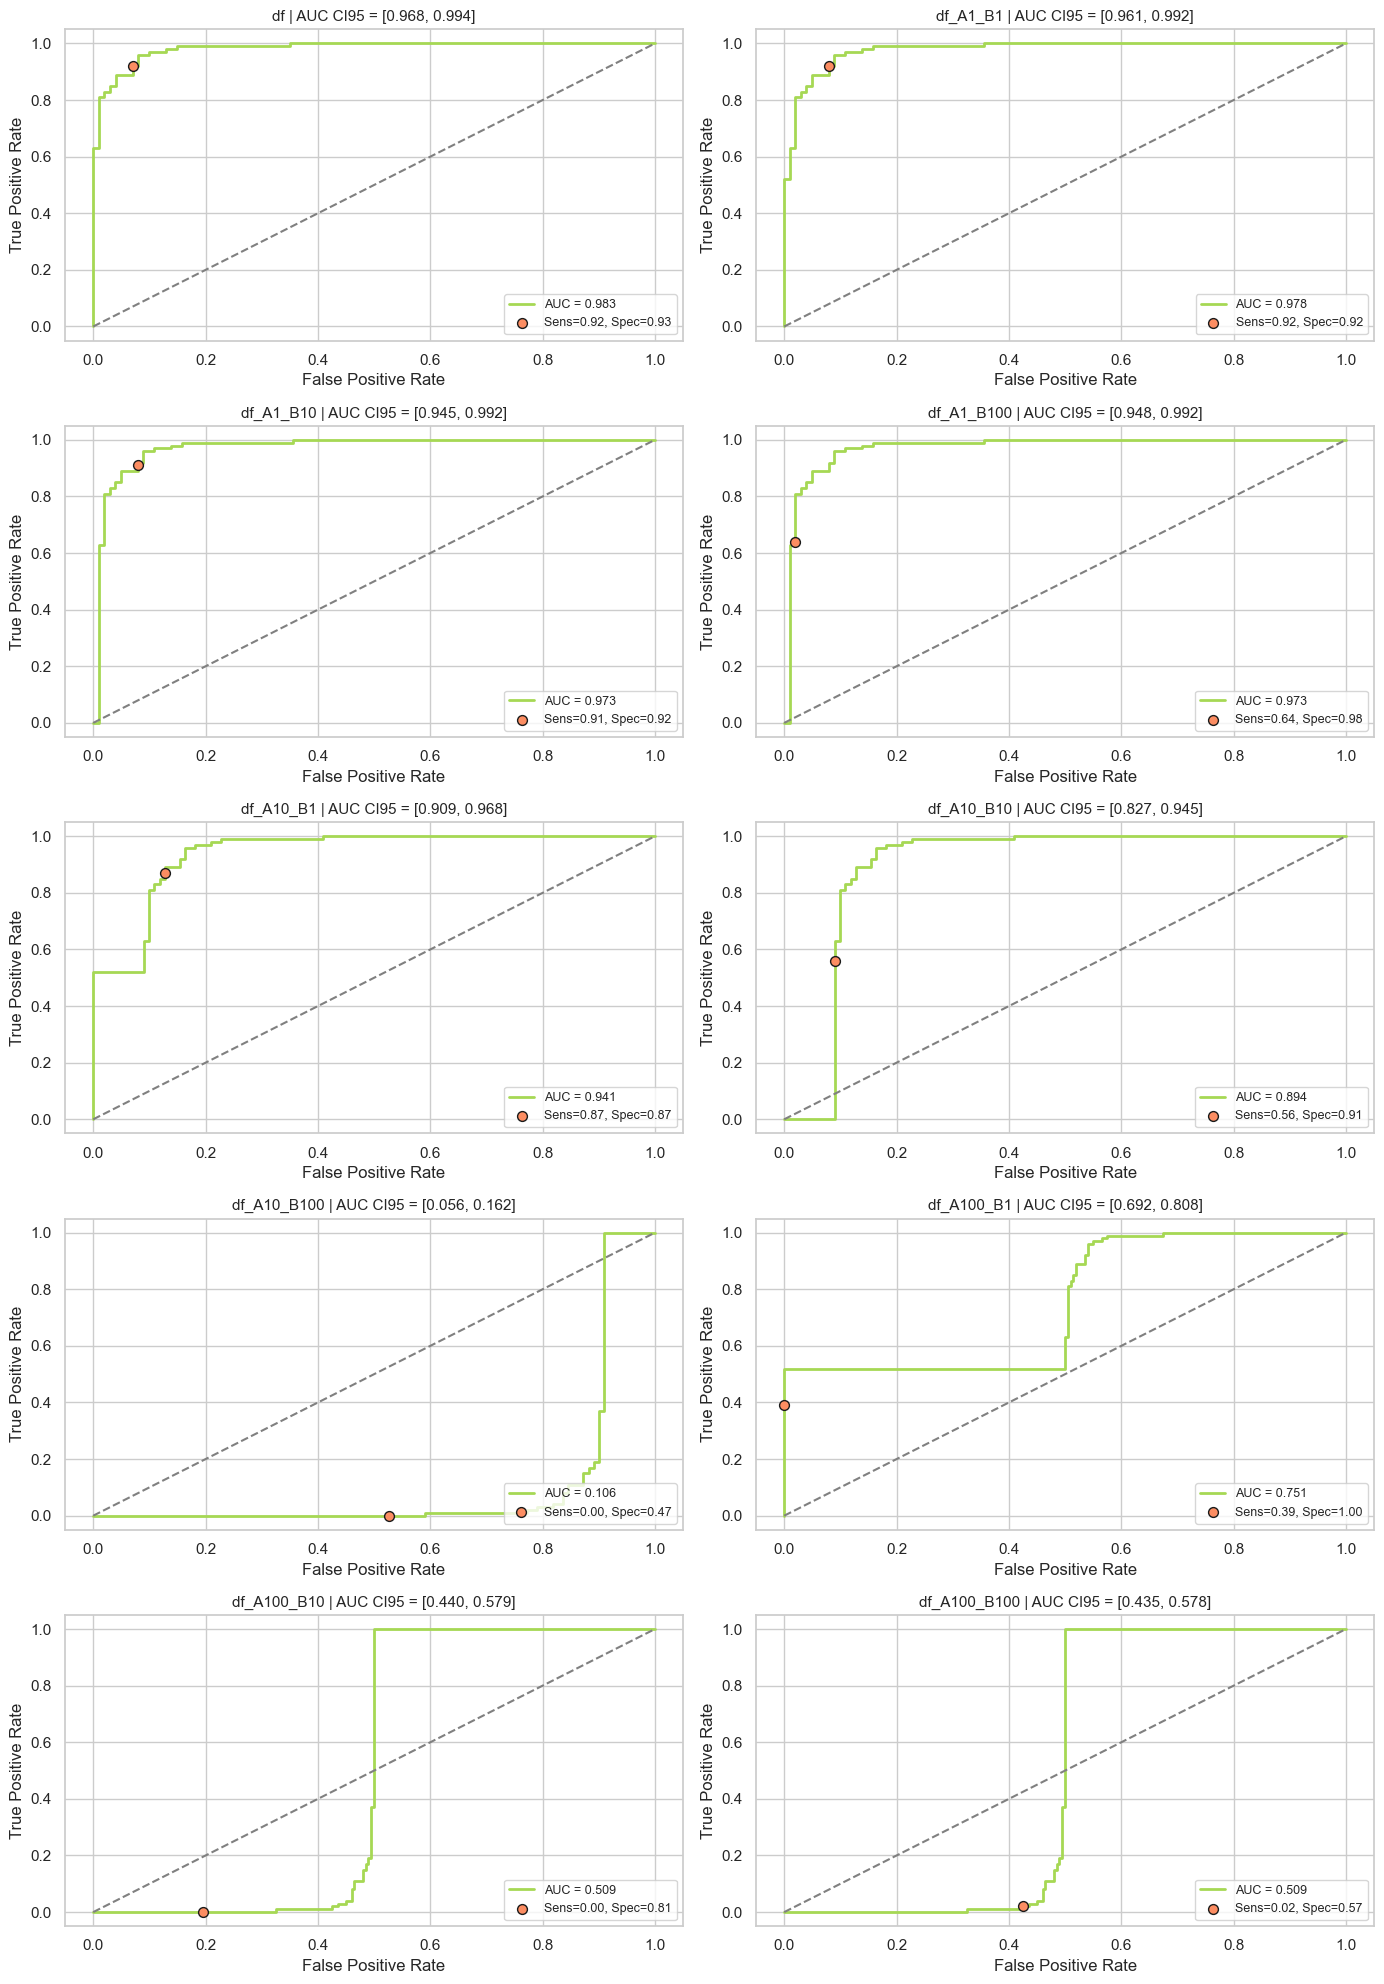

In [63]:
ROC_LINE_COLOR = PALETTE[4]
OPER_POINT_COLOR = PALETTE[1]

n_cols = 2
n_rows = int(np.ceil(len(df_variants) / n_cols))

fig, axes = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(14, 4 * n_rows)
)

axes = axes.flatten() if len(df_variants) > 1 else [axes]

for ax, (name, dfi) in zip(axes, df_variants.items()):
    X, y = prepare_binary_data(dfi, feature, selected_classes)

    logreg = LogisticRegression(solver='lbfgs', max_iter=200).fit(X, y)
    y_score = logreg.predict_proba(X)[:, 1]

    fpr, tpr, auc_score, sens, spec = roc_with_operating_point(y, y_score)
    ci_low, ci_high = bootstrap_auc_ci(y, y_score)

    ax.plot(fpr, tpr, color=ROC_LINE_COLOR, linewidth=2, label=f"AUC = {auc_score:.3f}")
    ax.scatter(1 - spec, sens, color=OPER_POINT_COLOR, edgecolor="k", zorder=5, s=50,
               label=f"Sens={sens:.2f}, Spec={spec:.2f}")
    ax.plot([0, 1], [0, 1], linestyle="--", color="gray")

    ax.set_title(f"{name} | AUC CI95 = [{ci_low:.3f}, {ci_high:.3f}]", fontsize=11)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right", fontsize=9)

for ax in axes[len(df_variants):]:
    ax.axis('off')

plt.tight_layout()
plt.show()


## [4] Для выбранной пары классов (включая класс с повторенными объектами) на первых четырех признаках вычислить уравнение множественной линейной регрессии, где Xi – признаки.
Используя полученное уравнение множественной линейной регрессии, на основе
каждого из датасетов из списка (df, df_A_B) сформировать новые датасеты logdf,
logdf_A_B, в каждом из которых есть только один признак Х, сформированный на основе
соответствующего уравнения множественной линейной регрессии, а переменная Y –
определяет отнесение к классу.

In [ ]:
from sklearn.linear_model import LinearRegression

multivar_features = feature_names[:4]

multivar_models = {}
logdfs = {}

print("Формируем множественные регрессии и новые logdf для каждого датасета...\n")

for key, dfi in df_variants.items():
    sub = dfi[dfi["target_name"].isin(selected_classes)].copy()
    X_train = sub[multivar_features].to_numpy()
    y_train = (sub["target_name"] == selected_classes[1]).astype(int).to_numpy()

    if len(np.unique(y_train)) < 2:
        print(f"[WARN] В датасете {key} нет двух классов — пропускаем.")
        continue

    lin = LinearRegression().fit(X_train, y_train)
    multivar_models[key] = lin

    coef = lin.coef_
    intercept = lin.intercept_
    print(f"Dataset: {key}")
    print(f"  intercept = {intercept:.6f}")
    for i, f in enumerate(multivar_features):
        print(f"  coef[{f}] = {coef[i]:.6f}")
    print("")

    X_all = dfi[multivar_features].to_numpy()
    X_lin = lin.predict(X_all)

    logdf = pd.DataFrame({
        "X_lin": X_lin,
        "Y": dfi["target_name"].apply(lambda v: 1 if v == selected_classes[1] else 0).to_numpy()
    })

    logdfs[f"log_{key}"] = logdf

print("Готово. Превью нескольких logdf:")
for k in list(logdfs.keys())[:5]:
    print(f"\n--- {k} ---")
    display(logdfs[k].head())

Формируем множественные регрессии и новые logdf для каждого датасета...

Dataset: df
  intercept = 0.518234
  coef[X1] = -0.125194
  coef[X2] = -0.112508
  coef[X3] = -0.113495
  coef[X4] = -0.095906

Dataset: df_A1_B1
  intercept = 0.516075
  coef[X1] = -0.119291
  coef[X2] = -0.118087
  coef[X3] = -0.108553
  coef[X4] = -0.100651

Dataset: df_A1_B10
  intercept = 0.518925
  coef[X1] = -0.106515
  coef[X2] = -0.129678
  coef[X3] = -0.098449
  coef[X4] = -0.111113

Dataset: df_A1_B100
  intercept = 0.518993
  coef[X1] = -0.115184
  coef[X2] = -0.121685
  coef[X3] = -0.105462
  coef[X4] = -0.104066

Dataset: df_A10_B1
  intercept = 0.502623
  coef[X1] = -0.082504
  coef[X2] = -0.152856
  coef[X3] = -0.077758
  coef[X4] = -0.130221

Dataset: df_A10_B10
  intercept = 0.519073
  coef[X1] = -0.102523
  coef[X2] = -0.133349
  coef[X3] = -0.095232
  coef[X4] = -0.114364

Dataset: df_A10_B100
  intercept = 0.518994
  coef[X1] = -0.115162
  coef[X2] = -0.121705
  coef[X3] = -0.105444
  coef[X4]

X_lin  Y
0  0.845514  1
1  1.159303  1
2  0.372869  0
3  0.576116  0
4 -0.050415  0


--- log_df_A1_B1 ---


X_lin  Y
0  0.845856  1
1  1.148132  1
2  0.380161  0
3  0.594820  0
4 -0.045686  0


--- log_df_A1_B10 ---


X_lin  Y
0  0.854859  1
1  1.132406  1
2  0.403293  0
3  0.641477  0
4 -0.028226  0


--- log_df_A1_B100 ---


X_lin  Y
0  0.850948  1
1  1.145325  1
2  0.389553  0
3  0.611462  0
4 -0.038151  0


--- log_df_A10_B1 ---


X_lin  Y
0  0.847988  1
1  1.078515  1
2  0.425608  0
3  0.711385  0
4 -0.016213  0

## [5] Для каждого из датасетов из списка (logdf, logdf_A_B) в своем пространстве Х-Y (количественный признак-класс) построить и визуализировать объекты, линию простой линейной регрессии и линию логистической регрессии. Регрессии строить на паре Х-Y (количественный признак-класс).
Оценить качество работы полученных на основе логистической регрессии
классификаторов, используя ROC кривые и восстановив на графике ROC кривых
определенную логистической регрессией точку классификации Sensitivity-Specificity и
доверительные интервалы CI95 бутстрепом (n=1000).
- Все полученные графики возможно расположить в две колонки, аналогично пункту [3].

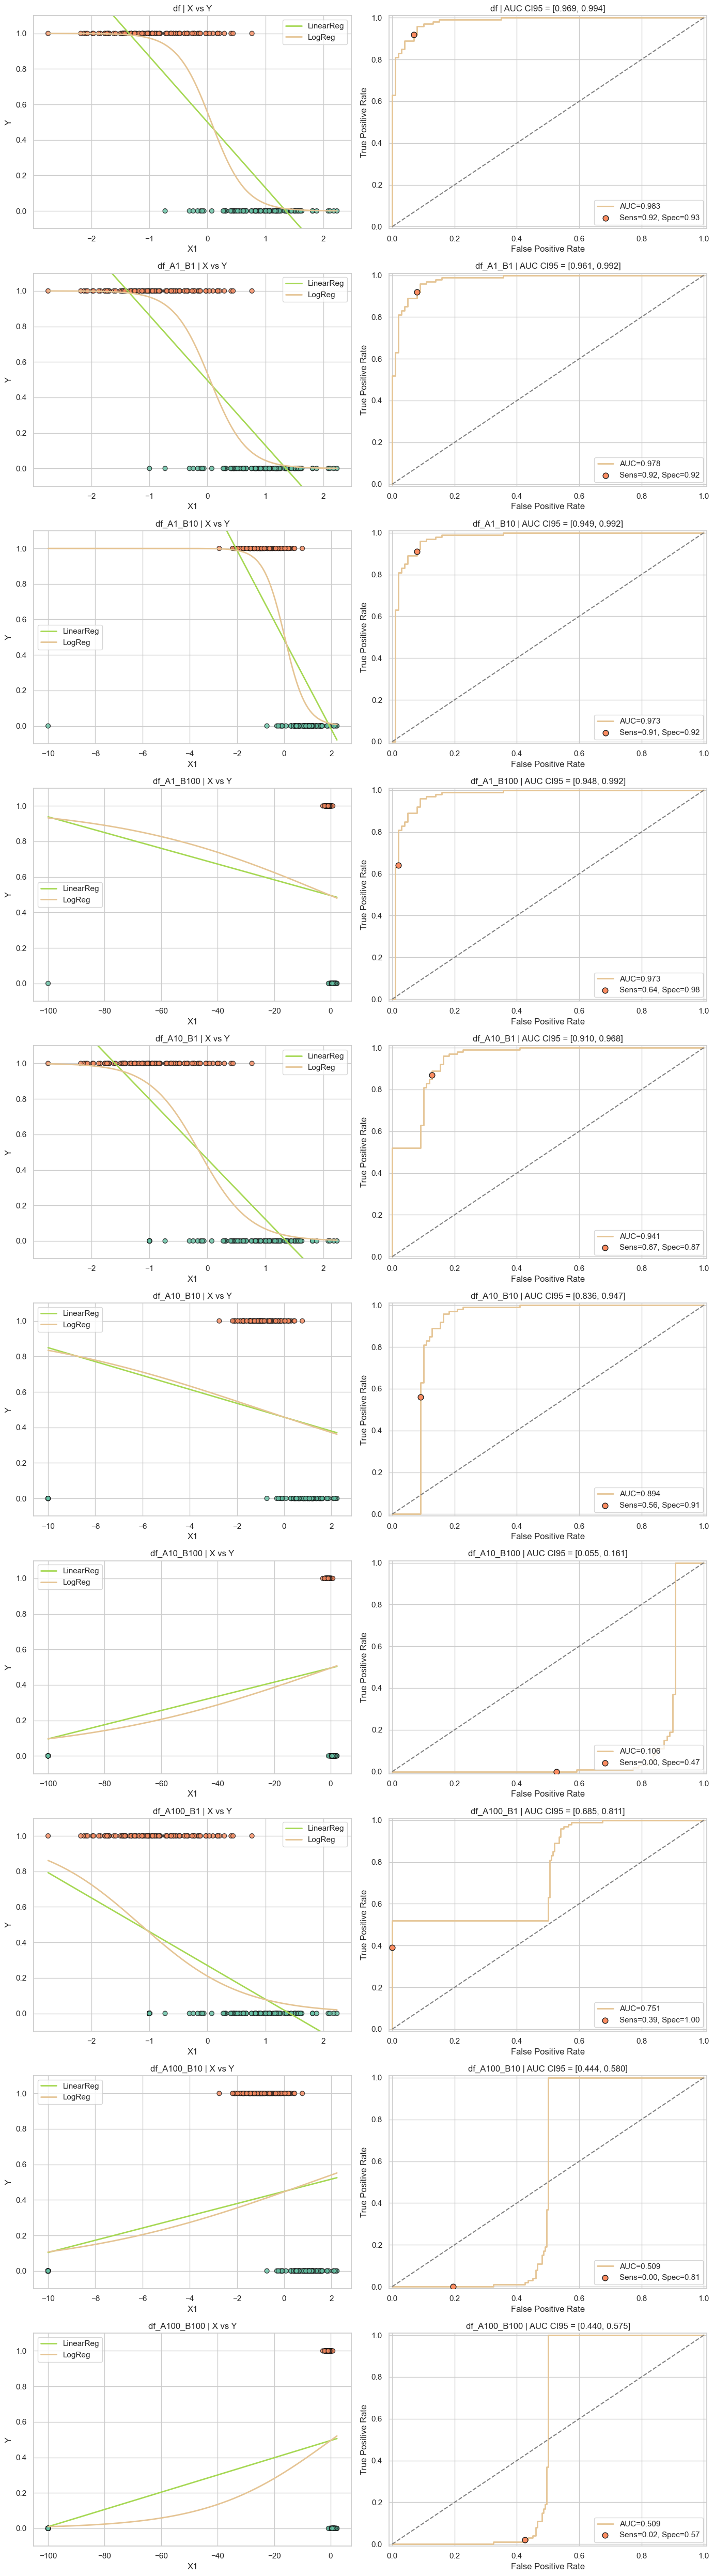

In [66]:
COLOR_NEG = PALETTE[0]   # class_0
COLOR_POS = PALETTE[1]   # class_1
LINE_COLOR_LIN = PALETTE[4]
LINE_COLOR_LOG = PALETTE[6]
OPER_POINT_COLOR = PALETTE[1]

fig, axes = plt.subplots(
    nrows=len(df_variants),
    ncols=2,
    figsize=(14, 5 * len(df_variants))
)

if len(df_variants) == 1:
    axes = np.array([axes])

for ax_row, (name, dfi) in zip(axes, df_variants.items()):
    X, y = prepare_binary_data(dfi, feature, selected_classes)

    linreg, logreg = fit_models(X, y)
    lin_scores = linreg.predict(X)
    log_scores = logreg.predict_proba(X)[:, 1]

    # Левая колонка: scatter + лин/лог регрессия
    ax_left = ax_row[0]
    # цвета точек по y
    colors = [COLOR_POS if yi == 1 else COLOR_NEG for yi in y]
    ax_left.scatter(X[:,0], y, c=colors, s=40, edgecolor="k", alpha=0.8)
    x_vals = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
    ax_left.plot(x_vals, linreg.predict(x_vals), color=LINE_COLOR_LIN, linewidth=2, label="LinearReg")
    ax_left.plot(x_vals, logreg.predict_proba(x_vals)[:, 1], color=LINE_COLOR_LOG, linewidth=2, label="LogReg")
    ax_left.set_title(f"{name} | X vs Y")
    ax_left.set_xlabel(feature)
    ax_left.set_ylabel("Y")
    ax_left.set_ylim(-0.1, 1.1)
    ax_left.legend()

    # Правая колонка: ROC-кривая
    ax_right = ax_row[1]
    fpr, tpr, _ = roc_curve(y, log_scores)
    auc_score = auc(fpr, tpr)
    ci_low, ci_high = bootstrap_auc_ci(y, log_scores)

    # Sensitivity-Specificity при пороге 0.5
    y_pred = (log_scores >= 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    sens = tp / (tp + fn) if (tp + fn)>0 else 0.0
    spec = tn / (tn + fp) if (tn + fp)>0 else 0.0

    ax_right.plot(fpr, tpr, color=LINE_COLOR_LOG, linewidth=2, label=f"AUC={auc_score:.3f}")
    ax_right.scatter(1-spec, sens, color=OPER_POINT_COLOR, edgecolor="k", zorder=6, s=60,
                     label=f"Sens={sens:.2f}, Spec={spec:.2f}")
    ax_right.plot([0,1],[0,1], linestyle="--", color="gray")
    ax_right.set_title(f"{name} | AUC CI95 = [{ci_low:.3f}, {ci_high:.3f}]")
    ax_right.set_xlabel("False Positive Rate")
    ax_right.set_ylabel("True Positive Rate")
    ax_right.set_xlim(-0.01, 1.01)
    ax_right.set_ylim(-0.01, 1.01)
    ax_right.legend(loc="lower right")

plt.tight_layout()
plt.show()


## [6] Для выбранной пары классов (включая класс с повторенными объектами), визуализировать один из датасетов df_A_B на всех парах переменных, построив на графиках объекты, линии множественной линейной регрессии, разделение классов на основе логистической регрессии решающей функцией с contour_plot уровнями классификации c подписанной вероятностью отнесения к целевому классу.

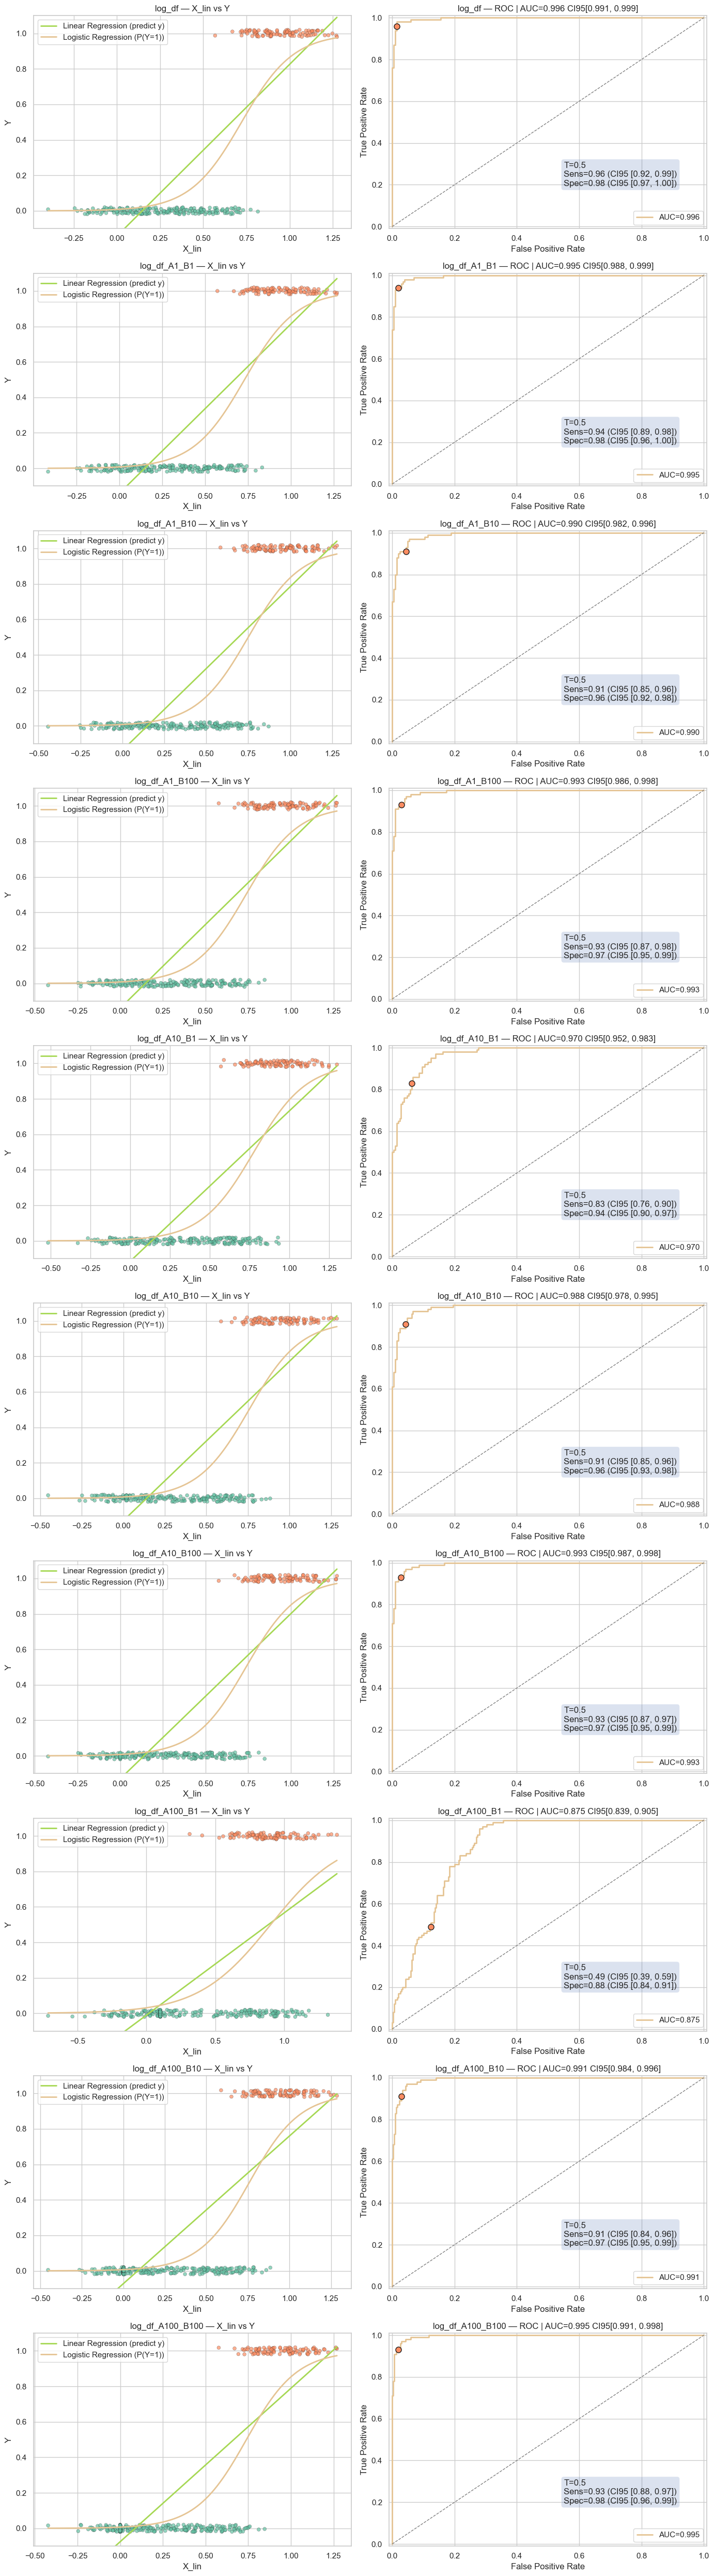

In [67]:
N_BOOT = 1000
ALPHA = 0.05

COLOR_NEG = PALETTE[0]
COLOR_POS = PALETTE[1]
LINE_COLOR_LIN = PALETTE[4]
LINE_COLOR_LOG = PALETTE[6]
OPER_POINT_COLOR = PALETTE[1]

def bootstrap_metrics(y_true, y_score, threshold=0.5, n_boot=N_BOOT, alpha=ALPHA, rng=rng):
    aucs = []
    sens_list = []
    spec_list = []
    n = len(y_true)
    for _ in range(n_boot):
        idx = rng.randint(0, n, n)
        yb = y_true[idx]
        sb = y_score[idx]
        if len(np.unique(yb)) < 2:
            continue
        fpr_b, tpr_b, _ = roc_curve(yb, sb)
        aucs.append(auc(fpr_b, tpr_b))
        ypred_b = (sb >= threshold).astype(int)
        try:
            tn, fp, fn, tp = confusion_matrix(yb, ypred_b).ravel()
            sens_b = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            spec_b = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        except ValueError:
            sens_b = 0.0
            spec_b = 0.0
        sens_list.append(sens_b)
        spec_list.append(spec_b)

    auc_ci = (np.nan, np.nan) if len(aucs) == 0 else (np.percentile(aucs, 100 * alpha / 2), np.percentile(aucs, 100 * (1 - alpha / 2)))
    sens_ci = (np.nan, np.nan) if len(sens_list) == 0 else (np.percentile(sens_list, 100 * alpha / 2), np.percentile(sens_list, 100 * (1 - alpha / 2)))
    spec_ci = (np.nan, np.nan) if len(spec_list) == 0 else (np.percentile(spec_list, 100 * alpha / 2), np.percentile(spec_list, 100 * (1 - alpha / 2)))

    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_main = auc(fpr, tpr)
    y_pred_main = (y_score >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_main).ravel()
    sens_main = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    spec_main = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    return {
        "fpr": fpr,
        "tpr": tpr,
        "auc": auc_main,
        "auc_ci": auc_ci,
        "sens": sens_main,
        "sens_ci": sens_ci,
        "spec": spec_main,
        "spec_ci": spec_ci
    }

n = len(logdfs)
fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(14, 5 * n))

if n == 1:
    axes = np.array([axes])

for i, (key, logdf) in enumerate(logdfs.items()):
    ax_left = axes[i, 0]
    ax_right = axes[i, 1]

    X_lin = logdf["X_lin"].to_numpy().reshape(-1, 1)
    y = logdf["Y"].to_numpy()

    lin = LinearRegression().fit(X_lin, y)
    x_vals = np.linspace(X_lin.min(), X_lin.max(), 300).reshape(-1,1)
    lin_pred = lin.predict(x_vals)

    logreg = LogisticRegression(solver="lbfgs", max_iter=200).fit(X_lin, y)
    log_prob = logreg.predict_proba(x_vals)[:, 1]
    y_score = logreg.predict_proba(X_lin)[:, 1]

    jitter = (rng.random(len(X_lin)) - 0.5) * 0.04
    colors = [COLOR_POS if yi == 1 else COLOR_NEG for yi in y]
    ax_left.scatter(X_lin[:,0], y + jitter, alpha=0.7, s=24, c=colors, edgecolor="k", linewidth=0.25)
    ax_left.plot(x_vals, lin_pred, color=LINE_COLOR_LIN, linewidth=2, label="Linear Regression (predict y)")
    ax_left.plot(x_vals, log_prob, color=LINE_COLOR_LOG, linewidth=2, label="Logistic Regression (P(Y=1))")
    ax_left.set_title(f"{key} — X_lin vs Y")
    ax_left.set_xlabel("X_lin")
    ax_left.set_ylabel("Y")
    ax_left.set_ylim(-0.1, 1.1)
    ax_left.legend()

    metrics = bootstrap_metrics(y, y_score, threshold=0.5, n_boot=N_BOOT, alpha=ALPHA, rng=rng)
    ax_right.plot(metrics["fpr"], metrics["tpr"], color=LINE_COLOR_LOG, linewidth=2, label=f"AUC={metrics['auc']:.3f}")
    ax_right.plot([0,1], [0,1], linestyle="--", color="gray", linewidth=1)

    ax_right.scatter(1 - metrics["spec"], metrics["sens"], color=OPER_POINT_COLOR, edgecolor="k", s=64, zorder=10)
    ann_text = (f"T=0.5\nSens={metrics['sens']:.2f} (CI95 [{metrics['sens_ci'][0]:.2f}, {metrics['sens_ci'][1]:.2f}])\n"
                f"Spec={metrics['spec']:.2f} (CI95 [{metrics['spec_ci'][0]:.2f}, {metrics['spec_ci'][1]:.2f}])")
    ax_right.annotate(ann_text,
                      xy=(1 - metrics["spec"], metrics["sens"]),
                      xytext=(0.55, 0.2),
                      textcoords="axes fraction",
                      bbox=dict(boxstyle="round,pad=0.3", alpha=0.2))

    ax_right.set_title(f"{key} — ROC | AUC={metrics['auc']:.3f} CI95[{metrics['auc_ci'][0]:.3f}, {metrics['auc_ci'][1]:.3f}]")
    ax_right.set_xlabel("False Positive Rate")
    ax_right.set_ylabel("True Positive Rate")
    ax_right.set_xlim(-0.01, 1.01)
    ax_right.set_ylim(-0.01, 1.01)
    ax_right.legend(loc="lower right")

plt.tight_layout()
plt.show()
